# <center>TMVA Classification Using Deep Neural Networks</center>

In this notebook we still classify di-Higgs new data with Deep Neural Networks meethod.

In [88]:
import ROOT
from ROOT import TMVA, TTree
import pandas as pd

ROOT.TMVA.Tools.Instance()
## For PYMVA methods
TMVA.PyMethodBase.PyInitialize()

import os
os.environ["KERAS_BACKEND"] = "tensorflow"

from keras.models import Sequential
from keras.optimizers import Adam, SGD
#from keras.initializers import TruncatedNormal
#from keras import initializations
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Reshape
#from keras.callbacks import ReduceLROnPlateau

import itertools
from sklearn.metrics import classification_report

from array import array
import numpy as np

from IPython.display import Image, display

### Filter dataset by region.

This function will let you filter your dataset by region. It's known that SR_1tag is very signal poor, while SR_2tag has a lot a signal.

In [23]:
def filter_region(file, region, signal):
    oldfile = ROOT.TFile(file)
    oldtree = oldfile.Nominal
    signal_file = ROOT.TFile(region+"_"+signal+"_s.root","recreate")
    signal_tree = oldtree.CloneTree(0)
    backg_file = ROOT.TFile(region+"_"+signal+"_b.root","recreate")
    backg_tree = oldtree.CloneTree(0)
    data_file = ROOT.TFile(region+"_"+signal+"_d.root","recreate")
    data_tree = oldtree.CloneTree(0)
    for entry in oldtree:
        if (entry.m_region == region):
            if (entry.sample == "data"):
                data_tree.Fill()
            elif (entry.sample == "Xtohh1000"): #signal
                signal_tree.Fill()
            else:
                backg_tree.Fill()
    signal_tree.AutoSave()   
    backg_tree.AutoSave()
    data_tree.AutoSave()
    return signal_tree, signal_file, backg_tree, backg_file, data_tree, data_file

#Use as
#tree, file = filter_region("data.root", "SR_1tag", "small.root")

## Declare Factory and Input Data

data.root has unlabeled data points (called data) and fakes points. For the background training we'll use only the fakes points.

In [24]:
signal_tree, signal_file, backg_tree, backg_file, data_tree, data_file = filter_region("all_1000.root", "SR_1tag", "Xtohh1000")

outputFile = ROOT.TFile.Open("Higgs_ClassificationOutput.root", "RECREATE")

# Factory
factory = ROOT.TMVA.Factory("TMVA_Higgs_Classification", outputFile,
                      "!V:ROC:Silent:Color:!DrawProgressBar:AnalysisType=Classification" )

#signal_tree.Print()

## Declare DataLoader(s)

The next step is to declare the DataLoader class that deals with input data abd variables 

We add first the signal and background trees in the data loader and then we
define the input variables that shall be used for the MVA training
note that you may also use variable expressions, which can be parsed by TTree::Draw( "expression" )]

We have two kinds of signals and for the training we have to use only one of them.

In [25]:
loader = ROOT.TMVA.DataLoader("dataset")

### global event weights per tree (see below for setting event-wise weights)
signalWeight     = 1.0
backgroundWeight = 1.0
   
### You can add an arbitrary number of signal or background trees
loader.AddSignalTree    ( signal_tree )
loader.AddBackgroundTree( backg_tree )
loader.SetWeightExpression("EventWeight")

not_cons = ['sample', 'EventWeight', 'EventNumber', 'm_region', 'm_FJNbtagJets', 'm_FJphi', 'm_FJeta', 'm_DTeta', 'm_DTphi']

## Define input variables 
for branch in backg_tree.GetListOfBranches():
    if branch.GetName() in not_cons:
        continue
    loader.AddVariable(branch.GetName())

## Setup Dataset(s)

Setup the DataLoader by splitting events in training and test samples. 
Here we use a random split and a fixed number of training and test events.

In [26]:
## Apply additional cuts on the signal and background samples (can be different)
mycuts = ROOT.TCut("")   ## for example: TCut mycuts = "abs(var1)<0.5 && abs(var2-0.5)<1";
mycutb = ROOT.TCut("")   ## for example: TCut mycutb = "abs(var1)<0.5";

loader.PrepareTrainingAndTestTree(mycuts, mycutb,
                                  "nTrain_Signal=70%:nTrain_Background=70%:SplitMode=Random:"
                                   "NormMode=NumEvents:!V" )

## DNN

In [27]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

from keras.models import Sequential
from keras.optimizers import Adam, SGD
#from keras.initializers import TruncatedNormal
#from keras import initializations
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Reshape
#from keras.callbacks import ReduceLROnPlateau

In [28]:
# Define model
model = Sequential()
model.add(Dense(64, kernel_initializer='glorot_normal', activation='sigmoid', input_dim=10))
#model.add(Dropout(0.2))
model.add(Dense(64, kernel_initializer='glorot_normal', activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(64, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(64, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(2, kernel_initializer='glorot_uniform', activation='softmax'))

# Set loss and optimizer
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['categorical_accuracy',])

# Store model to file
model.save('model_dense.h5')

# Print summary of model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                704       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 130       
Total params: 13,314
Trainable params: 13,314
Non-trainable params: 0
_________________________________________________________________


In [29]:
factory.BookMethod(loader, ROOT.TMVA.Types.kPyKeras, 'Keras_Dense',
        'H:!V:VarTransform=G:FilenameModel=model_dense.h5:'+\
        'NumEpochs=10:BatchSize=16:TriesEarlyStopping=10')

<ROOT.TMVA::MethodPyKeras object ("Keras_Dense") at 0x923bcf0>

## Train, Test and Evaluate Model

In [30]:
factory.TrainAllMethods()

# Here we test all methods using the test data set
factory.TestAllMethods()

# Here we evaluate all methods and compare their performances, computing efficiencies, 
# ROC curves etc.. using both training and tetsing data sets. Several histograms are 
# produced which can be examined with the TMVAGui or directly using the output file
factory.EvaluateAllMethods()

Train on 112 samples, validate on 28 samples
Epoch 1/10
112/112 [==============================] - 0s 3ms/step - loss: 0.7272 - categorical_accuracy: 0.4911 - val_loss: 0.6359 - val_categorical_accuracy: 0.4286

Epoch 00001: val_loss improved from inf to 0.63592, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 2/10
112/112 [==============================] - 0s 177us/step - loss: 0.6905 - categorical_accuracy: 0.5625 - val_loss: 0.6317 - val_categorical_accuracy: 0.5714

Epoch 00002: val_loss improved from 0.63592 to 0.63165, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 3/10
112/112 [==============================] - 0s 172us/step - loss: 0.6732 - categorical_accuracy: 0.6071 - val_loss: 0.6349 - val_categorical_accuracy: 0.4286

Epoch 00003: val_loss did not improve from 0.63165
Epoch 4/10
112/112 [==============================] - 0s 189us/step - loss: 0.6678 - categorical_accuracy: 0.5000 - val_loss: 0.6381 - val_categorical_accuracy: 0.5357

Ep

## Plot ROC Curve
We enable JavaScript visualisation for the plots

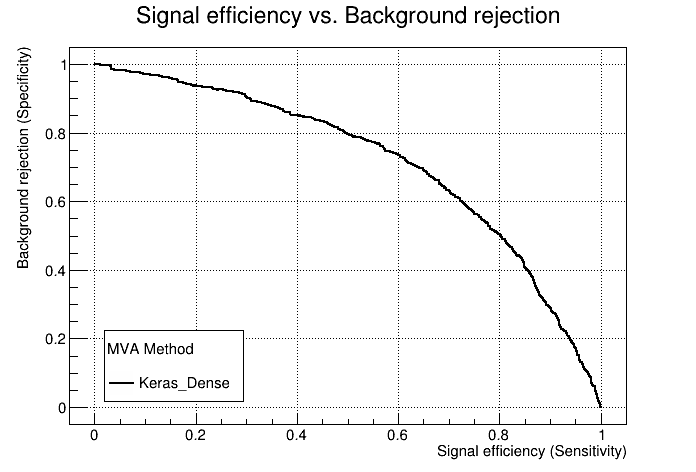

In [31]:
c1 = factory.GetROCCurve(loader)
c1.Draw()

## DNN Complete Function

In [32]:
def get_params(file):
    params = []
    first = 1
    with open(file, 'r') as fp:
        line = fp.readline().rstrip()
        while line:
            if (file.split('.')[1] == 'csv' and first):
                first = 0
                line = fp.readline().rstrip()
                continue
            params.append(line)
            line = fp.readline().rstrip()       
    return params

In [33]:
def DNN(params, training, model_input, comp_params, model_name, config):
    
    output_file = config+"_DNN_Classification.root"
    signal_file = config+"_s.root"
    backg_file = config+"_b.root"
    
    signal_input = ROOT.TFile(signal_file)
    signal_tree = signal_input.Nominal
    
    backg_input = ROOT.TFile(backg_file)
    backg_tree = backg_input.Nominal
    
    outputFile = ROOT.TFile.Open(output_file, "RECREATE")

    # Factory
    factory = ROOT.TMVA.Factory("TMVA_Higgs_Classification_"+config, outputFile,
                          "!V:ROC:Silent:Color:!DrawProgressBar:AnalysisType=Classification" )

    loader = ROOT.TMVA.DataLoader("dataset")

    ### global event weights per tree (see below for setting event-wise weights)
    #signalWeight     = 1.0
    #backgroundWeight = 1.0

    ### You can add an arbitrary number of signal or background trees
    loader.AddSignalTree    ( signal_tree )
    loader.AddBackgroundTree( backg_tree )
    loader.SetWeightExpression("EventWeight")
    
    not_cons = ['sample', 'EventWeight', 'EventNumber', 'm_region', 'm_FJNbtagJets', 'm_FJphi', 'm_FJeta', 'm_DTeta', 'm_DTphi']

    ## Define input variables 
    for branch in backg_tree.GetListOfBranches():
        if branch.GetName() in not_cons:
            continue
        loader.AddVariable(branch.GetName())
        
    mycuts = ROOT.TCut("")   ## for example: TCut mycuts = "abs(var1)<0.5 && abs(var2-0.5)<1";
    mycutb = ROOT.TCut("")   ## for example: TCut mycutb = "abs(var1)<0.5";


    loader.PrepareTrainingAndTestTree(mycuts, mycutb, training)
    
    # Model structure
    
    comp_params = comp_params.rstrip()
    comp_params = comp_params.split(',')
    loss = comp_params[0]
    
    comp_params.remove(loss)
    metrics = comp_params
    
    model = Sequential()
    model_input = model_input.rstrip()
    model_input = model_input.split(',')
    
    hidden_l = int(model_input[0])
    neurons = int(model_input[1])
    neurons_LF = int(model_input[2])
    k_init = model_input[3]
    activation_IL = model_input[4]
    activation_HL = model_input[5]
    activation_FL = model_input[6]
    
    print(type(neurons))
    
    model.add(Dense(neurons, kernel_initializer=k_init, activation=activation_IL, input_dim=10))
    for h in range(hidden_l):
        model.add(Dense(neurons, kernel_initializer=k_init, activation=activation_HL))
        
    model.add(Dense(neurons_LF, kernel_initializer=k_init, activation=activation_FL))
    
    # Set loss and optimizer
    model.compile(loss=loss, optimizer=Adam(), metrics=metrics)
    # Store model to file
    model.save(model_name)
    # Print summary of model
    model.summary()
    
    ## DNN method
    factory.BookMethod(loader,ROOT.TMVA.Types.kPyKeras, "Keras_Dense", params)
        
    factory.TrainAllMethods()
    
    factory.TestAllMethods()
    
    factory.EvaluateAllMethods()
    
    c1 = factory.GetROCCurve(loader)
    #c1.Draw()
    
    integ = factory.GetROCIntegral(loader, "Keras_Dense")
    
    print("ROC integral:", integ)
    
    outputFile.Close()
    signal_input.Close()
    backg_input.Close()
    
    return integ

## Parameters Combination

In [34]:
def write_combs_params(file_params, file_training, file_model, comp_params, model_name, arr_NumEpochs, arr_BatchSize, arr_nTrain_Signal, arr_nTrain_Background, arr_number_HL, arr_neurons, arr_neurons_LF, arr_k_init, arr_activation_IL, arr_activation_HL, arr_activation_FL, arr_loss, arr_metrics):
    comb_params = list(itertools.product(arr_NumEpochs, arr_BatchSize, arr_nTrain_Signal, arr_nTrain_Background, arr_number_HL, arr_neurons, arr_neurons_LF, arr_k_init, arr_activation_IL, arr_activation_HL, arr_activation_FL, arr_loss, arr_metrics))
    with open(file_params, 'w') as params, open(file_training, 'w') as training, open(file_model, 'w') as model, open(comp_params, 'w') as comp_p:
        model.write("number_HL,neurons,neurons_LF,k_init,activation_IL,activation_HL,activation_FL\n")
        for cp in comb_params:
            string1 = "H:!V:VarTransform=N_AllClasses:FilenameModel="+model_name+":NumEpochs="+str(cp[0])+":BatchSize="+str(cp[1])+":TriesEarlyStopping=10\n"
            params.write(string1)
            string2 = "nTrain_Signal="+str(cp[2])+"%:nTrain_Background="+str(cp[3])+"%:SplitMode=Random:NormMode=NumEvents:!V\n"
            training.write(string2)
            string3 = str(cp[4])+','+str(cp[5])+','+str(cp[6])+','+str(cp[7])+','+str(cp[8])+','+str(cp[9])+','+str(cp[10])+'\n'
            model.write(string3)
            string4 = str(cp[11])+','+str(cp[12])+'\n'
            comp_p.write(string4)

In [39]:
file_params="dnn_params2.txt"
file_training="dnn_training2.txt"
file_model="dnn_model2.csv"
file_comp_params='comp_params.txt'
model_name="model_dense.h5"
arr_NumEpochs=[100, 200]
arr_BatchSize=[100, 200]
arr_nTrain_Signal=[80]
arr_nTrain_Background=[80]
arr_number_HL=[3]
arr_neurons=[64]
arr_neurons_LF=[2]
arr_k_init=['glorot_normal']
arr_activation_IL=['sigmoid']
arr_activation_HL=['relu']
arr_activation_FL=['softmax']
arr_loss=['categorical_crossentropy']
arr_metrics=['categorical_accuracy']

In [40]:
write_combs_params(file_params, file_training, file_model, file_comp_params, model_name, arr_NumEpochs, arr_BatchSize, arr_nTrain_Signal, arr_nTrain_Background, arr_number_HL, arr_neurons, arr_neurons_LF, arr_k_init, arr_activation_IL, arr_activation_HL, arr_activation_FL, arr_loss, arr_metrics)

## Hyperparameter Optimization

In [41]:
def param_opt(config, params, training, model, comp_params, model_name):
    max_roc = 0
    best_params = ""
    best_train = ""
    best_model = ""
    print(config)
    print("===============")
    for i in range(len(params)):
        roc = DNN(params[i], training[i], model[i], comp_params[i], model_name, config)
        if roc > max_roc:
            max_roc = roc
            best_params = params[i]
            best_train = training[i]
            best_model = model[i]
    best_model = best_model.split(',')
    best_model_str = "numero_HL="+str(best_model[0])+", neurons="+str(best_model[1])+", neurons_LF="+str(best_model[2])+", k_init="+str(best_model[3])+", activation_IL="+str(best_model[4])+", activation_HL="+str(best_model[5])+", activation_FL="+str(best_model[6])
    print("best parameters:", best_params)
    print("best training:", best_train)
    print("best model:", best_model_str)
    print("ROC integral:", max_roc)
    return

In [42]:
params_path = "dnn_params2.txt"
params = get_params(params_path)
training_path = "dnn_training2.txt"
training = get_params(training_path)
configs = ["PreSel_0tag_Xtohh1000", "PreSel_1tag_Xtohh1000", "PreSel_2tag_Xtohh1000", 
           "QCDCR_0tag_Xtohh1000", "QCDCR_1tag_Xtohh1000", "QCDCR_2tag_Xtohh1000",
           "SR_0tag_Xtohh1000", "SR_1tag_Xtohh1000", "SR_2tag_Xtohh1000",
           "PreSel_0tag_Xtohh2000", "PreSel_1tag_Xtohh2000", "PreSel_2tag_Xtohh2000",
           "QCDCR_0tag_Xtohh2000", "QCDCR_1tag_Xtohh2000", "QCDCR_2tag_Xtohh2000",
           "SR_0tag_Xtohh2000", "SR_1tag_Xtohh2000", "SR_2tag_Xtohh2000"]
s_end = "_s.root"
b_end = "_b.root"
comp_params_path = "comp_params.txt"
comp_params = get_params(comp_params_path)
model_input_path = "dnn_model2.csv"
model_input = get_params(model_input_path)
model_name = "model_dense.h5"

In [43]:
DNN(params[0], training[0], model_input[0], comp_params[0], model_name, configs[7])

<class 'int'>
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 64)                704       
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 130       
Total params: 13,314
Trainable params: 13,314
Non-trainable params: 0
_________________________________________________________________
Train on 128 samples, validate on 32 samples
Epoch 1/100
128/128 [==============================] - 0s

0.46217069084625906

                         : 
                         : Evaluation results ranked by best signal efficiency and purity (area)
                         : -------------------------------------------------------------------------------------------------------------------
                         : DataSet       MVA                       
                         : Name:         Method:          ROC-integ
                         : dataset       Keras_Dense    : 0.462
                         : -------------------------------------------------------------------------------------------------------------------
                         : 
                         : Testing efficiency compared to training efficiency (overtraining check)
                         : -------------------------------------------------------------------------------------------------------------------
                         : DataSet              MVA              Signal efficiency: from test sample (from training sam

Warning in <TFile::Init>: file SR_1tag_Xtohh1000_s.root probably not closed, trying to recover
Info in <TFile::Recover>: SR_1tag_Xtohh1000_s.root, recovered key TTree:Nominal at address 8294
Warning in <TFile::Init>: successfully recovered 1 keys
Warning in <TFile::Init>: file SR_1tag_Xtohh1000_b.root probably not closed, trying to recover
Info in <TFile::Recover>: SR_1tag_Xtohh1000_b.root, recovered key TTree:Nominal at address 480267
Warning in <TFile::Init>: successfully recovered 1 keys
Warning in <TCanvas::Constructor>: Deleting canvas with same name: ROCCurve dataset class 0


In [45]:
param_opt(configs[8], params, training, model_input, comp_params, model_name)

SR_2tag_Xtohh1000
<class 'int'>
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 64)                704       
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 130       
Total params: 13,314
Trainable params: 13,314
Non-trainable params: 0
_________________________________________________________________
Train on 128 samples, validate on 32 samples
Epoch 1/100
128/128 [==================

Epoch 29/100
128/128 [==============================] - 0s 81us/step - loss: 0.6837 - categorical_accuracy: 0.6094 - val_loss: 0.5495 - val_categorical_accuracy: 0.6562

Epoch 00029: val_loss improved from 0.55131 to 0.54947, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 30/100
128/128 [==============================] - 0s 65us/step - loss: 0.6806 - categorical_accuracy: 0.6016 - val_loss: 0.5473 - val_categorical_accuracy: 0.6562

Epoch 00030: val_loss improved from 0.54947 to 0.54733, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 31/100
128/128 [==============================] - 0s 80us/step - loss: 0.6754 - categorical_accuracy: 0.6406 - val_loss: 0.5463 - val_categorical_accuracy: 0.6250

Epoch 00031: val_loss improved from 0.54733 to 0.54630, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 32/100
128/128 [==============================] - 0s 96us/step - loss: 0.6685 - categorical_accuracy: 0.6641 - val_loss: 0.5512 - val_ca

128/128 [==============================] - 0s 100us/step - loss: 0.5630 - categorical_accuracy: 0.6250 - val_loss: 0.4676 - val_categorical_accuracy: 0.6250

Epoch 00061: val_loss improved from 0.46936 to 0.46764, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 62/100
128/128 [==============================] - 0s 93us/step - loss: 0.5405 - categorical_accuracy: 0.6641 - val_loss: 0.4769 - val_categorical_accuracy: 0.6250

Epoch 00062: val_loss did not improve from 0.46764
Epoch 63/100
128/128 [==============================] - 0s 88us/step - loss: 0.5260 - categorical_accuracy: 0.7109 - val_loss: 0.5042 - val_categorical_accuracy: 0.5625

Epoch 00063: val_loss did not improve from 0.46764
Epoch 64/100
128/128 [==============================] - 0s 94us/step - loss: 0.5266 - categorical_accuracy: 0.7344 - val_loss: 0.5205 - val_categorical_accuracy: 0.5625

Epoch 00064: val_loss did not improve from 0.46764
Epoch 65/100
128/128 [==============================] - 0s 87us


Epoch 00007: val_loss improved from 0.57484 to 0.57382, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 8/100
128/128 [==============================] - 0s 52us/step - loss: 0.7022 - categorical_accuracy: 0.6250 - val_loss: 0.5730 - val_categorical_accuracy: 0.4688

Epoch 00008: val_loss improved from 0.57382 to 0.57301, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 9/100
128/128 [==============================] - 0s 56us/step - loss: 0.6997 - categorical_accuracy: 0.5938 - val_loss: 0.5708 - val_categorical_accuracy: 0.4688

Epoch 00009: val_loss improved from 0.57301 to 0.57082, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 10/100
128/128 [==============================] - 0s 37us/step - loss: 0.6968 - categorical_accuracy: 0.6250 - val_loss: 0.5673 - val_categorical_accuracy: 0.5000

Epoch 00010: val_loss improved from 0.57082 to 0.56731, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 11/100
128/128 [=====


Epoch 00036: val_loss improved from 0.46499 to 0.46080, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 37/100
128/128 [==============================] - 0s 47us/step - loss: 0.4933 - categorical_accuracy: 0.7266 - val_loss: 0.4665 - val_categorical_accuracy: 0.6250

Epoch 00037: val_loss did not improve from 0.46080
Epoch 38/100
128/128 [==============================] - 0s 62us/step - loss: 0.4826 - categorical_accuracy: 0.7266 - val_loss: 0.4515 - val_categorical_accuracy: 0.6562

Epoch 00038: val_loss improved from 0.46080 to 0.45146, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 39/100
128/128 [==============================] - 0s 40us/step - loss: 0.4732 - categorical_accuracy: 0.7188 - val_loss: 0.4848 - val_categorical_accuracy: 0.6250

Epoch 00039: val_loss did not improve from 0.45146
Epoch 40/100
128/128 [==============================] - 0s 50us/step - loss: 0.4659 - categorical_accuracy: 0.7266 - val_loss: 0.4572 - val_categorical_acc

128/128 [==============================] - 0s 90us/step - loss: 0.7025 - categorical_accuracy: 0.5469 - val_loss: 0.5795 - val_categorical_accuracy: 0.5312

Epoch 00017: val_loss did not improve from 0.57110
Epoch 18/200
128/128 [==============================] - 0s 106us/step - loss: 0.6988 - categorical_accuracy: 0.5938 - val_loss: 0.5905 - val_categorical_accuracy: 0.4375

Epoch 00018: val_loss did not improve from 0.57110
Epoch 19/200
128/128 [==============================] - 0s 92us/step - loss: 0.7018 - categorical_accuracy: 0.5312 - val_loss: 0.6041 - val_categorical_accuracy: 0.4062

Epoch 00019: val_loss did not improve from 0.57110
Epoch 20/200
128/128 [==============================] - 0s 87us/step - loss: 0.7079 - categorical_accuracy: 0.5234 - val_loss: 0.6140 - val_categorical_accuracy: 0.4062

Epoch 00020: val_loss did not improve from 0.57110
Epoch 21/200
128/128 [==============================] - 0s 110us/step - loss: 0.7149 - categorical_accuracy: 0.5234 - val_loss: 


Epoch 00006: val_loss improved from 0.57720 to 0.57246, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 7/200
128/128 [==============================] - 0s 68us/step - loss: 0.7031 - categorical_accuracy: 0.6328 - val_loss: 0.5676 - val_categorical_accuracy: 0.5312

Epoch 00007: val_loss improved from 0.57246 to 0.56759, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 8/200
128/128 [==============================] - 0s 67us/step - loss: 0.7010 - categorical_accuracy: 0.7266 - val_loss: 0.5652 - val_categorical_accuracy: 0.6250

Epoch 00008: val_loss improved from 0.56759 to 0.56523, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 9/200
128/128 [==============================] - 0s 62us/step - loss: 0.6992 - categorical_accuracy: 0.7734 - val_loss: 0.5644 - val_categorical_accuracy: 0.5938

Epoch 00009: val_loss improved from 0.56523 to 0.56442, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 10/200
128/128 [======


Epoch 00035: val_loss improved from 0.45094 to 0.44610, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 36/200
128/128 [==============================] - 0s 44us/step - loss: 0.5472 - categorical_accuracy: 0.7578 - val_loss: 0.4394 - val_categorical_accuracy: 0.6875

Epoch 00036: val_loss improved from 0.44610 to 0.43945, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 37/200
128/128 [==============================] - 0s 67us/step - loss: 0.5368 - categorical_accuracy: 0.7500 - val_loss: 0.4323 - val_categorical_accuracy: 0.6875

Epoch 00037: val_loss improved from 0.43945 to 0.43232, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 38/200
128/128 [==============================] - 0s 64us/step - loss: 0.5263 - categorical_accuracy: 0.7500 - val_loss: 0.4301 - val_categorical_accuracy: 0.6875

Epoch 00038: val_loss improved from 0.43232 to 0.43015, saving model to dataset/weights/TrainedModel_Keras_Dense.h5
Epoch 39/200
128/128 [===

Warning in <TFile::Init>: file SR_2tag_Xtohh1000_s.root probably not closed, trying to recover
Info in <TFile::Recover>: SR_2tag_Xtohh1000_s.root, recovered key TTree:Nominal at address 5526
Warning in <TFile::Init>: successfully recovered 1 keys
Warning in <TFile::Init>: file SR_2tag_Xtohh1000_b.root probably not closed, trying to recover
Info in <TFile::Recover>: SR_2tag_Xtohh1000_b.root, recovered key TTree:Nominal at address 244
Warning in <TFile::Init>: successfully recovered 1 keys
Warning in <TCanvas::Constructor>: Deleting canvas with same name: ROCCurve dataset class 0
Warning in <TFile::Init>: file SR_2tag_Xtohh1000_s.root probably not closed, trying to recover
Info in <TFile::Recover>: SR_2tag_Xtohh1000_s.root, recovered key TTree:Nominal at address 5526
Warning in <TFile::Init>: successfully recovered 1 keys
Warning in <TFile::Init>: file SR_2tag_Xtohh1000_b.root probably not closed, trying to recover
Info in <TFile::Recover>: SR_2tag_Xtohh1000_b.root, recovered key TTree:N

# Prediction

In [85]:
# Add weights
def v_out(tree, not_cons, variables, reader):
    
    h = ROOT.TH1D("","",60,-1,1)
    
    nevt = tree.GetEntries()

    vout = np.arange(nevt, dtype='float').reshape(1, nevt)

    for ievt, entry in enumerate(tree):
        i = 0    
        for branch in tree.GetListOfBranches():
            name = branch.GetName()
            if name in not_cons:
                continue
            variables[i][0] = getattr(entry,name)
            i += 1

        vout[0,ievt] = reader.EvaluateMVA(methodName)
        h.Fill(vout[0,ievt])
    
    return h, vout, variables

In [82]:
def gen_report_pred(background, signal, data, sep):
    background = list(background[0])
    signal = list(signal[0])
    data = list(data[0])
    bakg_t = [0]*len(background)
    signal_t = [1]*len(signal)
    y_predicted = background + signal
    y_test = bakg_t + signal_t
    for i in range(len(y_predicted)):
        if (y_predicted[i] < sep):
            y_predicted[i] = 0
        else:
            y_predicted[i] = 1
    for j in range(len(data)):
        if (data[j] < sep):
            data[j] = 0
        else:
            data[j] = 1
    print(classification_report(y_test, y_predicted, target_names=["background", "signal"]))
    return data

In [86]:
def predict(config, type_signal, methodName, sep):
    reader = TMVA.Reader( "!Color:!Silent" )
    
    dataPath = config + "_" + type_signal + "_d.root"
    bkgPath = config + "_" + type_signal + "_b.root"
    sigPath = config + "_" + type_signal + "_s.root"
    
    print(dataPath)
    
    dataFile = ROOT.TFile(dataPath)
    bkgFile = ROOT.TFile(bkgPath)
    sigFile = ROOT.TFile(sigPath)

    dataTree = dataFile.Nominal
    bkgTree = bkgFile.Nominal
    sigTree = sigFile.Nominal
    
    # Add Variables: We add variables to the reader exactly in the same way we did for the **DataLoader** during the training
    # We need to specify the address of the variable in order to pass it to TMVA when we iterate on the TTree
    variables = []
    i = 0
    
    not_cons = ['sample', 'EventWeight', 'EventNumber', 'm_region', 'm_FJNbtagJets', 'm_FJphi', 'm_FJeta', 'm_DTeta', 'm_DTphi']
    
    for branch in dataTree.GetListOfBranches():
        if branch.GetName() in not_cons:
            continue
        aux = array('f',[0])
        variables.append(aux)
        reader.AddVariable(branch.GetName(),variables[i])
        i = i+1
    
    # Setup Classifiers: We set up the classifiers by reading the input weights from the appropriate files
    # The file is stored for example as *dataset/weights/TMVAClassification_BDT.weights.xml
    weightfile = "dataset/weights/TMVA_Higgs_Classification_" + config + "_" + type_signal + "_" + methodName + ".weights.xml"
    name = ROOT.TString(methodName)
    reader.BookMVA( name, weightfile )
    
    # We iterate on the input event in the given TTree. We provide as input first the background tree 
    # We return the output results for the various methods in big numpy array [ number of methods x 
    # number of events]
    # We also fill an histogram for each method.
    # Note that is important to fill the arrays with the tree entries in order to pass the values to 
    # the TMVA::Reader
    hd, d_vout, variables = v_out(dataTree, not_cons, variables, reader)
    hs, s_vout, variables = v_out(sigTree, not_cons, variables, reader)
    hb, b_vout, variables = v_out(bkgTree, not_cons, variables, reader)
    
    print("Signal size:", len(s_vout[0]))
    print("Background size:", len(b_vout[0]))
    
    # Classification report
    prediction = gen_report_pred(b_vout, s_vout, d_vout, sep)
    
    print("Prediction size:", len(prediction))
    
    # Histogram
    c1 = ROOT.TCanvas("c1", "c1")
    c1.cd()
    hb.Draw()
    hs.SetLineColor(ROOT.kRed)
    hd.SetFillColor(ROOT.kGreen)
    hb.SetFillColor(ROOT.kBlue)
    hb.Draw()
    hs.Draw('Same')
    hd.Draw('Same')
    hb.SetTitle("background")
    hs.SetTitle("signal")
    hd.SetTitle("data")
    c1.BuildLegend()
        
    img_file = config + "_" + type_signal + "_" + methodName + "_hist.png"
    c1.SaveAs(img_file)
    
    dataFile.Close()
    sigFile.Close()
    bkgFile.Close()
    
    display(Image(filename=img_file)) 
    
    return prediction

SR_1tag_Xtohh1000_d.root
Signal size: 3553
Background size: 9262
              precision    recall  f1-score   support

  background       0.89      0.26      0.40      9262
      signal       0.32      0.92      0.48      3553

    accuracy                           0.44     12815
   macro avg       0.61      0.59      0.44     12815
weighted avg       0.74      0.44      0.42     12815

Prediction size: 81


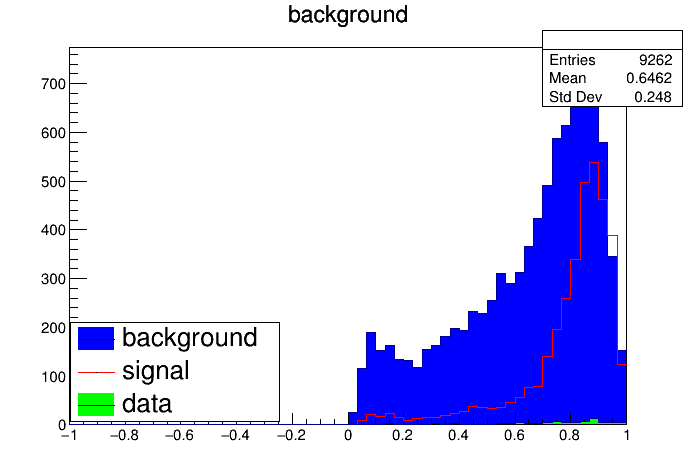

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file SR_1tag_Xtohh1000_Keras_Dense_hist.png has been created


In [89]:
config = "SR_1tag"
type_signal = "Xtohh1000"
methodName = "Keras_Dense"
sep = 0.5
asd = predict(config, type_signal, methodName, sep)